In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

In [2]:
import os
emails = pd.read_csv('../enron/emails.csv')
print(emails.shape)
emails.head()

KeyboardInterrupt: 

In [ ]:
out = None
for emails in pd.read_csv('../enron/emails.csv', chunksize = 10000):
    if out is None:
        out = emails.copy()
    else:
        out.append(emails)
    out.head()

In [ ]:
# extract to, from and body from each email
def email_parsing(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [ ]:
# compile all extracted data into a single dictionary
def emails_parsing(messages):
    emails = [email_parsing(message) for message in messages]
    return {
        'body': result_append(emails, 'body'), 
        'to': result_append(emails, 'to'), 
        'from_': result_append(emails, 'from')
    }

In [ ]:
# append all key results into single list
def result_append(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [ ]:
# create a new dataframe for extracted data
extracted_data = pd.DataFrame(emails_parsing(out['message']))

In [ ]:
extracted_data

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
4,,greg.piper@enron.com,phillip.allen@enron.com
...,...,...,...
9995,"shes pretty sexy, huh? are we getting togethe...",Brian Hoskins/HOU/ECT@ECT,eric.bass@enron.com
9996,i copied your idea - and it screwed up your name!,danielles@jonesgranger.com,eric.bass@enron.com
9997,"---------------------------Eric,Just a reminde...",Eric Bass/HOU/ECT@ECT,eric.bass@enron.com
9998,did you buy any enron in the 60s?,lwbthemarine@bigplanet.com,eric.bass@enron.com


In [ ]:
# check any NaN values
extracted_data.isnull().any()

body     False
to       False
from_    False
dtype: bool

In [ ]:
# drop empty values
extracted_data.drop(extracted_data.query("body == '' | to == '' | from_ == ''").index, inplace = True)

In [ ]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer = 'word', stop_words = stopwords, max_df = 0.5, min_df = 2)

In [ ]:
X = vect.fit_transform(extracted_data.body)

C:\Users\Dell\anaconda3\envs\enron_env\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


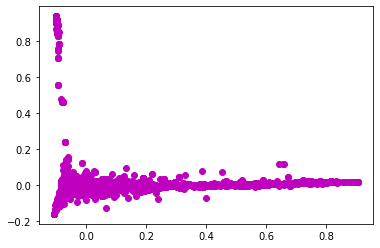

In [ ]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c = 'm')

In [ ]:
features = vect.get_feature_names()

C:\Users\Dell\anaconda3\envs\enron_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def top_msg_features(X, features, row_id, top_words = 25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_features(row, features, top_words)

In [ ]:
def top_tfidf_features(row, features, top_words = 20):
	# argsort produces the indices that orders the row by tf-idf value
	# reverse them (into descending order) and select the top words
    top_ids = np.argsort(row)[::-1][:top_words]
    top_features = [(features[i], row[i]) for i in top_ids]
    df = pd.DataFrame(top_features, columns=['features', 'score'])
    return df

In [ ]:
def top_msg_features(X, features, row_id, top_words = 25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_features(row, features, top_words)

In [ ]:
print(top_msg_features(X, features, 1, 10))

In [ ]:
def top_terms(X, features, grp_ids = None, min_tfidf = 0.1, top_words = 25):
    if grp_ids:
        msgs = X[grp_ids].toarray()
    else:
        msgs = X.toarray()
    msgs[msgs < min_tfidf] = 0
    # calculate the mean of each column across the selected rows (which results in a single row of tf-idf values)
    tfidf_means = np.mean(msgs, axis = 0)
    # then pass on to the previous func for picking out the top n words
    return top_tfidf_features(tfidf_means, features, top_words)

In [ ]:
# create classifier with 3 clusters and 100 iterations
clf = KMeans(n_clusters = 3, max_iter = 100, init = 'k-means++', n_init = 1)
labels = clf.fit_predict(X)

In [ ]:
X_dense = X.todense()
pca = PCA(n_components = 2).fit(X_dense)
coords = pca.transform(X_dense)

C:\Users\Dell\anaconda3\envs\enron_env\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Dell\anaconda3\envs\enron_env\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


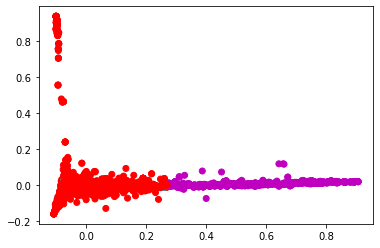

In [ ]:
label_colours = ['c', 'm', 'r']
colours = [label_colours[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c = colours)

In [ ]:
def top_words_per_cluster(X, y, features, min_tfidf = 0.1, top_words = 25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y == label) 
        features_df = top_terms(X, features, ids, min_tfidf = min_tfidf, top_words = top_words)
        features_df.label = label
        dfs.append(features_df)
    return dfs

In [ ]:
def plot_top_words(dfs):
    fig = plt.figure(figsize = (11, 8), facecolor = "w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad = 16, fontsize = 13)
        ax.set_title("cluster = " + str(df.label), fontsize = 15)
        ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (-2, 2))
        ax.barh(x, df.score, align = 'center', color = '#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1] + 1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom = 0.09, right = 0.97, left = 0.15, top = 0.95, wspace = 0.52)
    plt.show()

In [ ]:
tops = top_words_per_cluster(X, labels, features, 0.1, 25)

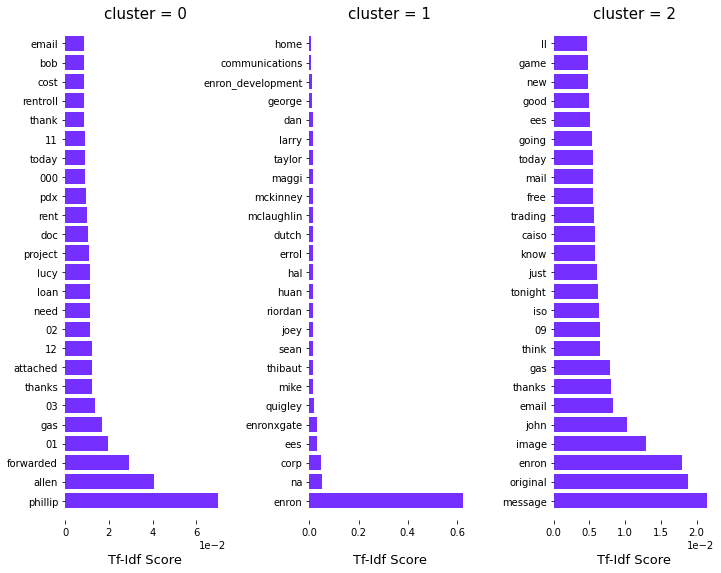

In [ ]:
plot_top_words(tops)